1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍 (O)
2. 이상치 처리 
    - lof, iso 유지 (O)
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가 (o)
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA (o)
    -> 성능에 치명적임 실행하지 않는 것이 좋을 것 같음

# Data Load

In [17]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    # 처리 안한게 더 좋았음
    # 처리 안한 것 : 0.944
    # 처리 한 것 : 최대 0.922
    do_count_trend=False,
    drop_count=False,

    get_useful_p_data=True,
    p_threshold=0.10,

    outlier_method='iso',
    iso_outlier_rate=0.008,

    do_resample=True,
    downsampled_pass_rate=1.0,
    upsampled_fail_rate_about_pass=0.30,
    upsample_method='adasyn',

    do_pca=False,
    # variance_rate=0.99
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[Process Log] Loading Raw Data...
[Process Log] Done

[Process Log] Processing Nan Value...
[Process Log] Done

[Process Log] Encoding Categorical Features...
[Process Log] Done

[Process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (89753, 23)
[Outlier-Remover Log] Without Outliers Shape : (89034, 23)
[Process Log] Done

[Process Log] T-Testing...
[Process Log] Done

[Process Log] Data Scaling (MinMaxScaler)...
[Process Log] Done

[Process Log] Train Test Spliting...
[Process Log] Done

[Process Log] Data Resampling (adasyn)...
[Process Log] Done

======================= [Done] =======================


# Modeling

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [19]:
model = LGBMClassifier(random_state=42)
# model = ExtraTreesClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
# model = XGBClassifier(random_state=42)

fold_f1_score = []
n_iter = 0
idx_list = []

for train_idx, val_idx in strat_folder.split(x_train, y_train):
    train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
    train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(train_data, train_label)

    val_pred = model.predict(val_data)
    val_f1_score = f1_score(val_label, val_pred)
    val_report = classification_report(val_label, val_pred)

    n_iter += 1
    fold_f1_score.append([n_iter, val_f1_score])
    idx_list.append([train_idx, val_idx])

    print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 Report : \n{val_report}")

fold_f1_score.sort(key=lambda x : x[1], reverse=True)
print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

[LightGBM] [Info] Number of positive: 16459, number of negative: 54912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 71371, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230612 -> initscore=-1.204859
[LightGBM] [Info] Start training from score -1.204859
StratifiedShuffleSplit 1 검증 데이터 Report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13728
         1.0       0.99      0.99      0.99      4115

    accuracy                           1.00     17843
   macro avg       1.00      0.99      0.99     17843
weighted avg       1.00      1.00      1.00     17843

[LightGBM] [Info] Number of positive: 16459, number of negative: 54912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [20]:
best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

[LightGBM] [Info] Number of positive: 16459, number of negative: 54912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 71371, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230612 -> initscore=-1.204859
[LightGBM] [Info] Start training from score -1.204859


LGBMClassifier(random_state=42)

# Validation

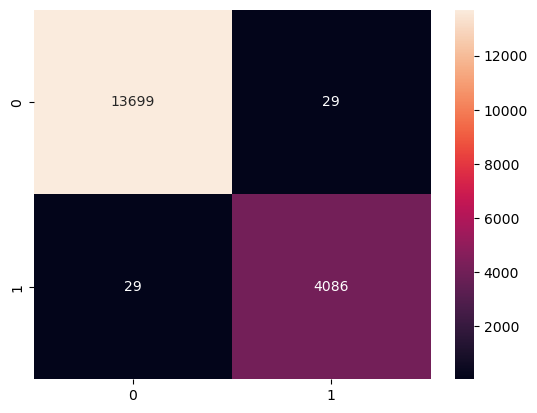

In [21]:
pred = model.predict(x_train.iloc[best_fold_val_idx])

cm = confusion_matrix(y_train[best_fold_val_idx], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

# Testing

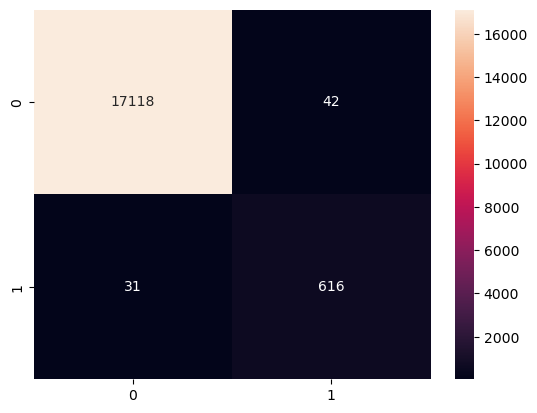

In [22]:
pred = model.predict(x_test)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17160
         1.0       0.94      0.95      0.94       647

    accuracy                           1.00     17807
   macro avg       0.97      0.97      0.97     17807
weighted avg       1.00      1.00      1.00     17807



In [24]:
print(f1_score(y_test, pred))

0.9440613026819923
